In [1]:
!nvidia-smi

Thu Feb 20 06:42:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive #인증받기 (본인 구글 계정 필요)
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import tensorflow
tensorflow.__version__

'1.15.0'

In [0]:
cd /gdrive/'My Drive'

/gdrive/My Drive


In [0]:
#데이터 다운 - 현재 계정으로
!unzip -n -qq /gdrive/'My Drive'/data/2019_KOHI_classification/valid.zip
!unzip -n -qq /gdrive/'My Drive'/data/2019_KOHI_classification/train.zip
!unzip -n -qq /gdrive/'My Drive'/data/2019_KOHI_classification/test.zip
# !cp /gdrive/'My Drive'/data/2019_KOHI_classification/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 /content
# !cp /gdrive/'My Drive'/data/2019_KOHI_classification/model_scbest.h5 /content
# !cp /gdrive/'My Drive'/data/2019_KOHI_classification/model_resbest.h5 /content
!mv /gdrive/'My Drive'/testcp /content
!mv /gdrive/'My Drive'/validcp /content
!mv /gdrive/'My Drive'/train /content

mv: inter-device move failed: '/gdrive/My Drive/testcp' to '/content/testcp'; unable to remove target: Directory not empty
mv: inter-device move failed: '/gdrive/My Drive/validcp' to '/content/validcp'; unable to remove target: Directory not empty
mv: inter-device move failed: '/gdrive/My Drive/train' to '/content/train'; unable to remove target: Directory not empty


In [0]:
!ls #현재 폴더 검색

'=3.5.5'		     sample_data   test_file.txt   training_logs.csv
 model_inceptionbestnow.h5   testcp	   train	   validcp


In [0]:
#필요라이브러리 설치
!pip install simpleITK
!pip install livelossplot
#!pip install keras==2.2.4

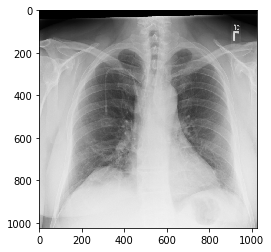

In [0]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
input_path = "/content/validcp/nm/0_normal.png"
refimg = sitk.ReadImage(input_path)
refimg = sitk.GetArrayFromImage(refimg)
plt.imshow(refimg,cmap='gray')
plt.show()

## 라이브러리 선언

In [0]:
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers, layers, utils
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger,ModelCheckpoint
from livelossplot import PlotLossesKeras
from keras import backend as K 
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

Using TensorFlow backend.


In [0]:
#여기는 학습하고 테스트할때 기본이되는 API 
def get_model(base_model, 
              layer, 
              lr=1e-3, 
              input_shape=(224,224,1), 
              classes=2,
              activation="softmax",
              dropout=None, 
              pooling="avg", 
              weights=None,
              pretrained="imagenet"): 
    base = base_model(input_shape=input_shape,
                      include_top=False,
                      weights=pretrained) 
    if pooling == "avg": 
        x = GlobalAveragePooling2D()(base.output) 
    elif pooling == "max": 
        x = GlobalMaxPooling2D()(base.output) 
    elif pooling is None: 
        x = Flatten()(base.output) 
    if dropout is not None: 
        x = Dropout(dropout)(x) 
    x = Dense(classes, activation=activation)(x) 
    model = Model(inputs=base.input, outputs=x) 
    if weights is not None: 
        model.load_weights(weights) 
    for l in model.layers[:layer]:
        l.trainable = False 
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], 
                 optimizer=optimizers.Adam(lr)) 
    return model

def get_modelinfer(base_model, 
              layer, 
              lr=1e-3, 
              input_shape=(224,224,1), 
              classes=2,
              activation="softmax",
              dropout=None, 
              pooling="avg", 
              weights=None,
              pretrained=None): 
    base = base_model(input_shape=input_shape,
                      include_top=False,
                      weights=pretrained) 
    if pooling == "avg": 
        x = GlobalAveragePooling2D()(base.output) 
    elif pooling == "max": 
        x = GlobalMaxPooling2D()(base.output) 
    elif pooling is None: 
        x = Flatten()(base.output) 
    if dropout is not None: 
        x = Dropout(dropout)(x) 
    x = Dense(classes, activation=activation)(x) 
    model = Model(inputs=base.input, outputs=x) 
    if weights is not None: 
        model.load_weights(weights) 
    for l in model.layers[:layer]:
        l.trainable = False 
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], 
                 optimizer=optimizers.Adam(lr)) 
    return model

## 파라미터 설정

In [0]:
TRAINING_LOGS_FILE = "/content/training_logs.csv"
TEST_FILE = "/content/test_file.txt"
MODEL_FILE = "/content/"

BASEPATH = '/content/'

training_data_dir = BASEPATH + "train" # 10 000 * 2
validation_data_dir = BASEPATH + "validcp" # 2 500 * 2
test_data_dir = BASEPATH + "testcp" # 12 500

# Hyperparams
IMAGE_SIZE = 1024
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
IMG_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
EPOCHS = 20
BATCH_SIZE = 8
TEST_SIZE = 400

## 통계 분석을 위한 함수

In [0]:
from IPython.display import clear_output 
from sklearn.metrics import roc_auc_score,roc_curve,auc,cohen_kappa_score, accuracy_score, f1_score, classification_report
input_size = 512
def performance_measure(y_actual1, y_actual2, y_hat):
    #abnormal : 1
    #normal : 0
        
    TP = 0
    FP = 0
    TN = 0
    FN = 0
     
    for i in range(len(y_hat)): 
        #print( y_actual[i], y_hat[i])
        if y_hat[i] == y_actual1[i] == 1:
            TN += 1          
        if y_hat[i] == 1 and y_actual1[i] == 0:
            FP += 1
        if y_hat[i] == y_actual1[i] == 0:
            TP +=1
        if y_hat[i] == 0 and y_actual1[i] == 1:
            FN +=1
    
    print(TP, FN, TN, FP) 
    sensitivity  = float(TP) / float(TP+FN)
    specificity  = float(TN) / float(TN+FP)
    pos_pred_val = float(TP) / float(TP+FP) #TP+FP
    neg_pred_val = float(TN) / float(TN+FN)
    print("acc",accuracy_score(y_actual1, y_hat))
    print(sensitivity,specificity,pos_pred_val,neg_pred_val)
    print(classification_report(y_actual1, y_hat))
    print("roc",roc_auc_score(y_hat,y_actual2))
    return(TP, FN, TN, FP)

## 데이터 로딩 (train, test, valid)

In [0]:
# Data augmentation
#증강없이
#training_data_generator = ImageDataGenerator(rescale=1./255)

#일부증강
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False)
#많은증강
# training_data_generator = ImageDataGenerator(
#     featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
#     rotation_range=5,
#     width_shift_range=0.,
#     height_shift_range=0.,
#     shear_range=0.,
#     zoom_range=[0.9, 1.1],
#     channel_shift_range=0.,
#     fill_mode='constant',
#     cval=0.,
#     horizontal_flip=False,
#     vertical_flip=False,
#     rescale=None)

validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Data preparation #폴더 순서대로 클래스 순서
# class_mode는 클래스가 2개이면 binary 클래스가 3개이상이면 categorigical 로 변경
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(int(IMAGE_WIDTH/2), int(IMAGE_HEIGHT/2)),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True)
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(int(IMAGE_WIDTH/2), int(IMAGE_HEIGHT/2)),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True)
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(int(IMAGE_WIDTH/2), int(IMAGE_HEIGHT/2)),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 2002 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


## 학습하기

In [0]:
#정학한 내용은 keras documentation을 참고하길 바람 
#input_shape: 네트워크 input size
#incude_top = True 제일 뒤 FL layer까지 사용하고 학습하겠다. fine_tuing할때는 이렇게 하지말고 다음과 같이한다.
#include_top = False 그리고 FL layer를 본인이 하고자 하는 태스크에 맞게 진행한다.
#pretrained 는 keras에서 학습한 웨이트를 사용할 것인지 아닌지 선택한다. 'None'이면 웨이트 없이 학습

#네트워크 변경 다양한 형태의 모델이름을 넣어서 학습 (케라스 import name하고 동일하게 들어가야함) 
#get_model함수는 원하는 네트워크의 이름을 파라미터로 받아서 여러가지 네트워크를 학습해볼 수 있음
#뒷단의 필요한 레이어를 wrapping 한 API 

#ResNet50
#InceptionV3
#DenseNet121


input_size = 512
model = get_model(DenseNet121, 0, 5e-5, dropout=None, input_shape=(input_size,input_size,3),activation='sigmoid',classes = 1,
    pretrained= "imagenet")
model.summary()

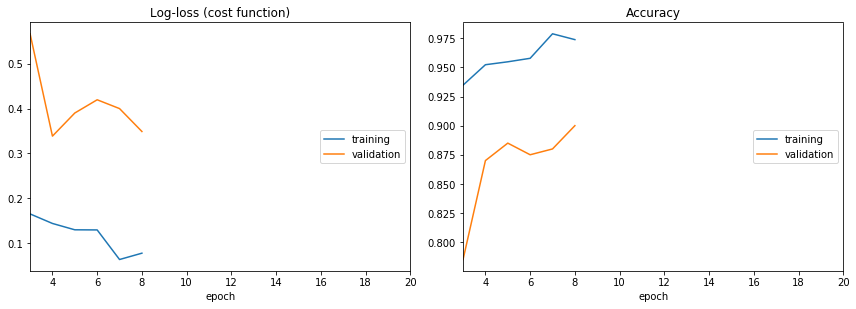

Log-loss (cost function):
training   (min:    0.064, max:    0.338, cur:    0.078)
validation (min:    0.339, max:    0.567, cur:    0.349)

Accuracy:
training   (min:    0.848, max:    0.979, cur:    0.974)
validation (min:    0.785, max:    0.900, cur:    0.900)
Epoch 9/20
 98/250 [==========>...................] - ETA: 1:51 - loss: 0.0466 - acc: 0.9847

In [0]:
# Training
modelpath = MODEL_FILE+"model_densebestnow.h5" #모델이름은 변경해주기
checkpoint = ModelCheckpoint(modelpath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print(int(len(training_generator.filenames) // (BATCH_SIZE)))
model.fit_generator(
    training_generator,
    steps_per_epoch= int(len(training_generator.filenames) // (BATCH_SIZE)),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps= int(len(validation_generator.filenames) // (BATCH_SIZE)),
    callbacks=[checkpoint, PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)


## 테스트

In [0]:
#네트워크 변경
#ResNet50
#InceptionV3
#DenseNet121
#현재 학습한 모델 - 모델명만 변경하여 진행하기
model_weights="/content/model_inceptionbestnow.h5"
model = get_modelinfer(InceptionV3,layer=0,classes=1,input_shape=(512, 512, 3),activation="sigmoid",weights=model_weights)
model.summary()

In [0]:
cpreds1 = []
cpreds2 = []
ctrues = []

# Testing
open(TEST_FILE,"w")
probabilities = model.predict_generator(test_generator, TEST_SIZE)

for index, probability in enumerate(probabilities):
    image_path = test_data_dir + "/" +test_generator.filenames[index]
    print(image_path,index)
    print(probability)
    #img = mpimg.imread(image_path)
#     with open(TEST_FILE,"a") as fh:
#         fh.write(str(probability[0]) + " for: " + image_path + "\n")
    #plt.imshow(img)
    if probability > 0.5:
        #plt.title("%.2f" % (probability[0]*100) + "% pneumonia")
        print("%.2f" % (probability[0]*100) + "% pneumonia")
        cpreds1.append(1)
    else:
        #plt.title("%.2f" % ((1-probability[0])*100) + "% normal")
        print("%.2f" % ((1-probability[0])*100) + "% normal")
        cpreds1.append(0)
    #plt.show()
    
    #asan  
    if "normal" in image_path:
        ctrues.append(0)
    else:
        ctrues.append(1)
    cpreds2.append(probability)

In [0]:
# evaluate the keras model
#(TP, FN, TN, FP)
performance_measure(cpreds1,cpreds2,ctrues)

(193, 7, 196, 4)
('acc', 0.9725)
(0.965, 0.98, 0.9796954314720813, 0.9655172413793104)
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       197
           1       0.98      0.97      0.97       203

   micro avg       0.97      0.97      0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400

('roc', 0.9976999999999999)


(193, 7, 196, 4)

## ROC curve 그리기

Text(0.5,0,'False Positive Rate')

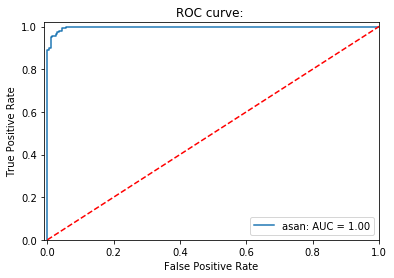

In [0]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ctrues, cpreds2)
    roc_auc[i] = auc(fpr[i], tpr[i])
fig = plt.figure()    
plt.title('ROC curve: ')
plt.plot(fpr[1], tpr[1], label = 'asan: AUC = %0.2f' % roc_auc[1])

plt.legend(loc = 'lower right')
plt.plot([0, 1.2], [0, 1.2],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#fig.savefig('/content/test2png.png', dpi=300)